# Dyna Maze

In [1]:
from copy import deepcopy
import numpy as np
import gym
from collections import deque
import matplotlib.pyplot as plt
import heapq 
import seaborn as sns
import io
from PIL import Image
import os

In [2]:
class Maze:
    def __init__(self, custom_map):
        # parse from the custom_map
        self.states = []
        self.obstacles = []
        self.start = None
        self.goal = None
        self.NUM_ROWS = len(custom_map)
        self.NUM_COLS = len(custom_map[0])
        
        for i in range(self.NUM_ROWS):
            for j in range(self.NUM_COLS):
                cell = custom_map[i][j]
                if cell == 'S':
                    self.start = (i, j)
                elif cell == 'G':
                    self.goal = (i, j)
                elif cell == 'O':
                    self.obstacles.append((i, j))
                self.states.append((i, j))   
        # initial state
        self.reset()

        # all possible actions
        self.ACTION_LEFT = 0
        self.ACTION_DOWN = 1
        self.ACTION_RIGHT = 2
        self.ACTION_UP = 3
        self.actions = [self.ACTION_LEFT, self.ACTION_DOWN, self.ACTION_RIGHT, self.ACTION_UP]
        self.optimal_path_length = self.BFS()
        
        # randomized reward
        self.random_reward = np.random.normal(1, 0.1, size=(1))[0]

        
        
    # check whether a state can be reached
    def is_reachable(self, state):
        return state in self.states and state not in self.obstacles

    # reset the maze state
    def reset(self):
        self.curr_state = self.start

    # compute next state given current state and action
    def next_state(self, state, action):
        x, y = state
        next_state = None
        if action == 0:
            next_state = (x, y - 1)
        elif action == 1:
            next_state = (x + 1, y)
        elif action == 2:
            next_state = (x, y + 1)
        else:
            next_state = (x - 1, y)
            
        next_state = next_state if self.is_reachable(next_state) else state
        return next_state

    # take a step
    def step(self, action):
        x, y = self.curr_state
        next_state = None
        if action == 0:
            next_state = (x, y - 1)
        elif action == 1:
            next_state = (x + 1, y)
        elif action == 2:
            next_state = (x, y + 1)
        else:
            next_state = (x - 1, y)
            
        next_state = next_state if self.is_reachable(next_state) else self.curr_state
        done = next_state == self.goal
        
        # if reward is good, update the random reward value
        if done:
            reward = self.random_reward
            self.random_reward = np.random.normal(1, 0.1, size=(1))[0]
        else:
            reward = 0.0
        
        # reward = 1.0 if done else 0.0
        
        self.curr_state = next_state
        return next_state, reward, done
    
    # prior (state, action) pairs predicted to lead to this state
    def prev_pairs(self, state):
        x, y = state
        prev_pairs = []
        
        # previous up
        prev_state = (x - 1, y)
        if prev_state not in self.states:
            if state != self.goal:
                prev_pairs.append((state, self.ACTION_UP))
        else:
            if prev_state not in self.obstacles and prev_state != self.goal:
                prev_pairs.append((prev_state, self.ACTION_DOWN))
        
        # previous down
        prev_state = (x + 1, y)
        if prev_state not in self.states:
            if state != self.goal:
                prev_pairs.append((state, self.ACTION_DOWN))
        else:
            if prev_state not in self.obstacles and prev_state != self.goal:
                prev_pairs.append((prev_state, self.ACTION_UP))
                
        # previous left
        prev_state = (x, y - 1)
        if prev_state not in self.states:
            if state != self.goal:
                prev_pairs.append((state, self.ACTION_LEFT))
        else:
            if prev_state not in self.obstacles:
                prev_pairs.append((prev_state, self.ACTION_RIGHT))
            
        # previous right
        prev_state = (x, y + 1)
        if prev_state not in self.states:
            if state != self.goal:
                prev_pairs.append((state, self.ACTION_RIGHT))
        else:
            if prev_state not in self.obstacles and prev_state != self.goal:
                prev_pairs.append((prev_state, self.ACTION_LEFT))
        
        return prev_pairs
    
    # generate custom map based on custom_map using different resolution
    def generate_custom_map(custom_map, times = 1):
        temp_map = deepcopy(custom_map)
        for temp_times in range(1, times):
            new_map = []
            if temp_times % 2 == 0:
                for row in temp_map:
                    if 'G' in row:
                        new_map.append(row)
                        row_list = list(row)
                        row_list[row_list.index('G')] = 'F'
                        new_map.append(''.join(row_list))
                    elif 'S' in row:
                        new_map.append(row)
                        row_list = list(row)
                        row_list[row_list.index('S')] = 'F'
                        new_map.append(''.join(row_list))
                    else:
                        new_map.append(row)
                        new_map.append(row)
                        
            else:
                for row in temp_map:
                    new_row = ''
                    for cell in row:
                        if cell == 'G':
                            new_row += cell
                            new_row += 'F'
                        elif cell == 'S':
                            new_row += cell
                            new_row += 'F'
                        else:
                            new_row += cell
                            new_row += cell
                    new_map.append(new_row)
            temp_map = new_map
        return temp_map
    
    def BFS(self):
        frontier = [self.start]
        visited = set()
        steps = -1
        
        while len(frontier) > 0:
            width = len(frontier)
            for i in range(width):
                x, y = frontier.pop(0)
                if (x, y) == self.goal:
                    break

                visited.add((x, y))
                # up
                if (x - 1, y) in self.states and (x - 1, y) not in self.obstacles:
                    if (x - 1, y) not in visited and (x - 1, y) not in frontier:
                        frontier.append((x - 1, y))
                # down
                if (x + 1, y) in self.states and (x + 1, y) not in self.obstacles:
                    if (x + 1, y) not in visited and (x + 1, y) not in frontier:
                        frontier.append((x + 1, y))
                # left
                if (x, y - 1) in self.states and (x, y - 1) not in self.obstacles:
                    if (x, y - 1) not in visited and (x, y - 1) not in frontier:
                        frontier.append((x, y - 1))
                # right
                if (x, y + 1) in self.states and (x, y + 1) not in self.obstacles:
                    if (x, y + 1) not in visited and (x, y + 1) not in frontier:
                        frontier.append((x, y + 1))
            steps += 1
        return steps

In [3]:
# wrapper class for Dyna-Q
class Dyna_Q:
    def __init__(self, maze):
        # Dyna-Q params
        self.model = {}       # deterministic model, model[state][action] = (reward, next_state)
        self.previous_pairs = {} # the previous pair (state, action) for each state
        self.alpha = 0.1     # step update size
        self.gamma = 0.9     # decay factor
        self.epsilon = 0.1    # epsilon greedy factor
        self.maze = maze      # the maze object
        self.Q_values = {s : {a : 0 for a in self.maze.actions} for s in self.maze.states} 
                              # action values, Q_values[state][action] = 0.0
        self.Q_map = np.zeros((self.maze.NUM_ROWS, self.maze.NUM_COLS))
                              # proxy to display q value map
        
        self.steps_per_episode = [] 
                              # timesteps to reach goal
        self.theta = 1e-5     # the small threshold for prioritized sweeping
        self.pQueue = []      # the priority sweeping queue for (TD_error, (state, action))
        self.state_priorities = {}
                              # state-priority pair. helper for updading pQueue
        self.updates_til_optimal = 0
                              # number of Q-updates until optimal solution
        self.delta = 1e-7     # small threshold that Q_values have converged
        self.expired = set()   # expired pqueue entries (priority, (state, action))
        self.entry_finder = {} # (state, action): (priority, (state, action))
        self.update_heatmap = np.zeros((self.maze.NUM_ROWS, self.maze.NUM_COLS))
        
        self.current_Q_update = None # the current state-action pair of Q update (used in GIF generation)
        self.current_num_Q_update = 0 # the current number of Q updates made
        self.gif_steps = -1       # make a frame per some updates 
        self.gif_frames = []   # the place to store all images for the gif
        
        self.max_frames = -1   # the max_number of frames in the gif to be specified
        
#         self.T = np.zeros((self.maze.NUM_ROWS * self.maze.NUM_COLS, self.maze.NUM_ROWS * self.maze.NUM_COLS))
#                                # the transition matrix for the need term
            
#         self.need_matrix = np.zeros((self.maze.NUM_ROWS * self.maze.NUM_COLS, self.maze.NUM_ROWS * self.maze.NUM_COLS))
#                                # the need-matrix to find the need term.
            
        # initialize the transition matrix T
        # original the next state transitions should be random (all q_values are 0)
#         for state in self.maze.states:
#             state_num = state[0] * self.maze.NUM_COLS + state[1]
#             for action in self.maze.actions:
#                 next_state = self.maze.next_state(state, action)
#                 next_state_num = next_state[0] * self.maze.NUM_COLS + next_state[1]
#                 self.T[state_num, next_state_num] += 0.25

        # initialize the state-value map
        # obstacles have -1
        for obstacle in self.maze.obstacles:
            self.Q_map[obstacle[0]][obstacle[1]] = -1
            
        # initialize the prev_state
        for state in self.maze.states:
            self.previous_pairs[state] = []
        
    # perform one Q-learning update
    # return the difference
    def Q_update(self, state, action, next_state, reward):
        current_Q = self.Q_values[state][action]
        max_next_Q = np.amax(list(self.Q_values[next_state].values()))
        change = self.alpha * (reward + self.gamma * max_next_Q - current_Q)
        self.Q_values[state][action] = current_Q + change
        self.updates_til_optimal += 1
        self.update_heatmap[state[0], state[1]] += 1
        
        # making a gif if needed
        self.current_num_Q_update += 1
        self.current_Q_update = (state, action)
        
        # update the q_map
        self.Q_map[state[0], state[1]] = max(self.Q_map[state[0], state[1]], self.Q_values[state][action])
        
        # update T and need_matrix
        state_num = state[0] * self.maze.NUM_COLS + state[1]
        max_action = np.argmax(list(self.Q_values[state].values()))

#         for action in self.maze.actions:
#             if action != max_action:     # if it is not max action
#                 _next_state = self.maze.next_state(state, action)
#                 next_state_num = _next_state[0] * self.maze.NUM_COLS + _next_state[1]
#                 self.T[state_num][next_state_num] = self.epsilon / len(self.maze.actions)
#             else:
#                 _next_state = self.maze.next_state(state, max_action)
#                 next_state_num = _next_state[0] * self.maze.NUM_COLS + _next_state[1]
#                 self.T[state_num][next_state_num] = 1 - self.epsilon + self.epsilon / len(self.maze.actions)
                
#         # update need_matrix
#         self.need_matrix = np.linalg.solve(np.identity(self.NUM_COLS * self.NUM_ROWS) 
#                                            - self.T * self.gamma, np.identity(self.NUM_COLS * self.NUM_ROWS))

        return change
        
    # select action by epsilon greedy
    def epsilon_greedy(self, state, Q_values):
        x = np.random.rand()
        if x > self.epsilon:
            action_values = np.array(list(Q_values[state].values()))
            return np.random.choice(np.flatnonzero(np.isclose(action_values, action_values.max())))
        else:
            return np.random.choice(self.maze.actions)
        
    # update the model from previous experience
    def update_model(self, state, action, reward, next_state):
        # if first time meet state
        if state not in self.model:
            self.model[state] = {}
        self.model[state][action] = (reward, next_state)
        if next_state not in self.previous_pairs:
            self.previous_pairs[next_state] = []
        if (state, action) not in self.previous_pairs[next_state]:
            self.previous_pairs[next_state].append((state, action))
    
    # default uniform sweeping
    def uniform_sweep(self, n):
        for i in range(n):
            state = list(self.model.keys())[np.random.choice(len(self.model))]
            action = np.random.choice(list(self.model[state].keys()))
            reward, next_state = self.model[state][action]
            self.Q_update(state, action, next_state, reward)
    
    # insert into pqueue
    def pq_push(self, priority, state, action):
        # if already in the pqueue
        if (state, action) in self.entry_finder:
            old_entry = self.entry_finder[(state, action)]
            old_priority = old_entry[0]
            # if exactly the same as old, do not care duplicate
            # note that priority here is negative
            if old_priority <= priority:
                return
            else:
                self.expired.add(old_entry)   # the old entry should be expired
        self.entry_finder[(state, action)] = (priority, (state, action))
        heapq.heappush(self.pQueue, (priority, (state, action)))
    
    # pop from pqueue
    def pq_pop(self):
        top_entry = None
        while self.entry_finder:
            top_entry = heapq.heappop(self.pQueue)
            if top_entry not in self.expired:  # if it is not deleted
                self.entry_finder.pop(top_entry[1], None)
                return top_entry
            else:                              # if it has expired
                self.expired.remove(top_entry)
    
    # prioritized sweeping method
    def prioritized_sweep(self, n):
        sweep = 0
        while sweep < n and len(self.entry_finder) > 0:
            # to choose the entry using gain * need
            
            state, action = self.pq_pop()[1]        # first one is the top one
            reward, next_state = self.model[state][action]
#                 print(state, reward)
#                 if reward == 1:
#                     print("good")
            self.Q_update(state, action, next_state, reward)
    
            # if no frame limit or not exceed frame limit, consider save a frame
            if self.max_frames == -1 or len(self.gif_frames) < self.max_frames:
                # save a frame to the frame list
                if self.gif_steps != -1:
                    if self.current_num_Q_update % self.gif_steps == 0:
                        
                        ax = sns.heatmap(self.Q_map, cmap="Reds", mask=self.Q_map == -1, square=True, linewidths=1, linecolor='darkgrey')
                        ax.set_title('Prioritized sweeping update heatmap')
                        ax.set_xlabel('x')
                        ax.set_ylabel('y')
                        ax.set_facecolor("black")
                        ax.text(8, 0.5, 'Goal', fontsize=12)


                        for _state in self.maze.states:
                            if _state not in self.maze.obstacles and _state != self.maze.goal:
                                y_start, x_start = _state
                                # for each direction: DOWN, RIGHT, UP, LEFT
                                # (x_change, y_change, x_padding, y_padding)
                                directions = [(0, 0.001, 0.5, 0.65, 1), 
                                              (0.001, 0, 0.65, 0.5, 2), 
                                              (0, -0.001, 0.5, 0.35, 3), 
                                              (-0.001, 0, 0.35, 0.5, 0)]
                                for direction in directions:
                                    x_change, y_change, x_padding, y_padding, _action = direction

                                    r = (hex(int(255 - self.Q_values[_state][_action] * 116)))[2:]
                                    g = (hex(int(255 * (1 - self.Q_values[_state][_action]))))[2:]
                                    b = (hex(int(255 * (1 - self.Q_values[_state][_action]))))[2:]
                                    lw = '2' if (_state, _action) == self.current_Q_update else '0.75'

                                    arrow_color = '#' + r + g + b

                                    ax.arrow(x_start + x_padding,          #x start point
                                             y_start + y_padding,          #y start point
                                             x_change,               #change in x 
                                             y_change,               #change in y
                                             head_width=0.27,         #arrow head width
                                             head_length=0.22,        #arrow head length
                                             width=0.1,              #arrow stem width
                                             fc=arrow_color,             #arrow fill color
                                             ec='black',             #arrow edge color
                                             linewidth=lw
                                            )

                        ax.text(self.maze.NUM_COLS / 3 * 2, self.maze.NUM_ROWS + 1, 
                                '#Q-updates: ' + str(self.current_num_Q_update), fontsize=11)

                        # save the frame to the frame list
                        buf = io.BytesIO()
                        figure = ax.get_figure()    
                        figure.savefig(buf, format='png')
                        figure.clf()
                        self.gif_frames.append(buf)
            
            # Loop for all S¯,A¯ predicted to lead to S:
            for prev_pair in self.previous_pairs[state]:
                prev_state, prev_action = prev_pair
                # predicted_reward = 1.0 if state == self.maze.goal else 0.0
                predicted_reward = self.maze.random_reward if state == self.maze.goal else 0.0
                P = np.abs(self.TD_error(prev_state, prev_action, state, predicted_reward))
                if P > self.theta: 
#                     need = self.need_matrix[]
                    self.pq_push(-P, prev_state, prev_action)
            sweep += 1
#                         print(self.pQueue)
            
            
    # take a step. If done, reset maze and go back to start state
    def step(self, action):
        next_state, reward, done = self.maze.step(action)
#         print(next_state, reward, done, info)
        if done:
            self.maze.reset()
        return reward, next_state, done
        
    
    # the main algorithm using uniform sweeping
    # max_iters: number of episodes or timesteps to run, depending on mode
    # n: times of planning per real action
    def run_uniform(self, max_iters, n, time_mode="episode"):
        self.maze.reset()
        num_steps = 0
        total_rewards = deque()
        
        if time_mode == "episode": 
            episode = 0
            while episode < max_iters:
                state = self.maze.curr_state
                action = self.epsilon_greedy(state, self.Q_values)
                reward, next_state, done = self.step(action)
                total_rewards.append(reward)
                num_steps += 1
                # if success, record number of steps to success
                if done:
                    self.steps_per_episode.append(num_steps)
                    num_steps = 0
                    episode += 1
                self.Q_update(state, action, next_state, reward)
                self.update_model(state, action, reward, next_state)
                self.uniform_sweep(n)
        
        elif time_mode == "timestep":
            for i in range(max_iters):
                state = self.maze.curr_state
                action = self.epsilon_greedy(state, self.Q_values)
                reward, next_state, done = self.step(action)
                total_rewards.append(reward)
                num_steps += 1
                # if success, record number of steps to success
                if done:
                    self.steps_per_episode.append(num_steps)
                    num_steps = 0
                self.Q_update(state, action, next_state, reward)
                self.update_model(state, action, reward, next_state)
                self.uniform_sweep(n)
        return np.cumsum(total_rewards)
    
    # run_uniform until convergence
    # factor is the resolution factor
    def run_uniform_converge(self, n, factor):
        self.maze.reset()
        num_steps = 0
        total_rewards = deque()
        
        while True:
            state = self.maze.curr_state
            action = self.epsilon_greedy(state, self.Q_values)
            reward, next_state, done = self.step(action)
            total_rewards.append(reward)
            num_steps += 1
            # if success, record number of steps to success
            if done:
                self.steps_per_episode.append(num_steps)
                if num_steps <= 14 * factor * 1.1:
                    break
                num_steps = 0
            self.Q_update(state, action, next_state, reward)
            self.update_model(state, action, reward, next_state)
            self.uniform_sweep(n)
        return np.cumsum(total_rewards)
    
    # main algorithm using prioritized sweeping
    # max_iters: max number of timesteps or episodes
    # n: number of sweeps per action taken
    # time_mode: count by timesteps or episodes
    # gif_steps: record a frame every gif_steps of Q_updates. If is -1, do not make gif
    # max_frames: max number of frames to take. If is -1, record until ends running
    def run_prioritized(self, max_iters, n, time_mode="episode", gif_steps=1000, max_frames=-1):
        self.maze.reset()
        self.gif_steps = gif_steps
        self.max_frames = max_frames
        num_steps = 0
        total_rewards = deque()
        
        if time_mode == "episode": 
            episode = 0
            while episode < max_iters:
                state = self.maze.curr_state
                action = self.epsilon_greedy(state, self.Q_values)
                reward, next_state, done = self.step(action)
                
                total_rewards.append(reward)
                num_steps += 1
                # if success, record number of steps to success
                if done:
                    self.steps_per_episode.append(num_steps)
                    num_steps = 0
                    episode += 1
        
                self.update_model(state, action, reward, next_state)
                P = np.abs(self.TD_error(state, action, next_state, reward))
#                 if state == (2, 8):
#                     print(state, action, next_state, reward, P)

                if (P > self.theta):
                    # compute the need term
#                     current_state_num = state[0] * self.maze.NUM_COLS + state[1]
#                     next_state_num = next_state[0] * self.maze.NUM_COLS + next_state[1]
#                     need = self.need_matrix[current_state_num][next_state_num]
                    self.pq_push(-P, state, action)
                
                self.prioritized_sweep(n)
        
        elif time_mode == "timestep":
            for i in range(max_iters):
                state = self.maze.curr_state
                action = self.epsilon_greedy(state, self.Q_values)
                reward, next_state, done = self.step(action)
                
                total_rewards.append(reward)
                num_steps += 1
                # if success, record number of steps to success
                if done:
                    self.steps_per_episode.append(num_steps)
                    num_steps = 0
                self.update_model(state, action, reward, next_state)
                P = np.abs(self.TD_error(state, action, next_state, reward))
#                 if state == (2, 8):
#                     print(state, action, next_state, reward, P)

                if (P > self.theta):
                    self.pq_push(-P, state, action)
                
                self.prioritized_sweep(n)
        return np.cumsum(total_rewards)
    
    def run_prioritized_converge(self, n, factor):
        self.maze.reset()
        num_steps = 0
        total_rewards = deque()
        
        while True:
            state = self.maze.curr_state
            action = self.epsilon_greedy(state, self.Q_values)
            reward, next_state, done = self.step(action)

            total_rewards.append(reward)
            num_steps += 1
            # if success, record number of steps to success
            if done:
                self.steps_per_episode.append(num_steps)
                if num_steps <= 14 * factor * 1.1:
                    break
                num_steps = 0

            self.update_model(state, action, reward, next_state)
            P = np.abs(self.TD_error(state, action, next_state, reward))
#                 if state == (2, 8):
#                     print(state, action, next_state, reward, P)

            if (P > self.theta):
                self.pq_push(-P, state, action)

            self.prioritized_sweep(n)
        return np.cumsum(total_rewards)
    
    # calculate the TD error for prioritozed sweeping
    def TD_error(self, state, action, next_state, reward):
        current_Q = self.Q_values[state][action]
        max_next_Q = np.amax(list(self.Q_values[next_state].values()))
#         if state == (1, 8):
#             print(current_Q)           
        return reward + self.gamma * max_next_Q - current_Q
    
    def print_policy(self):
        directions = ["←", "↓", "→", "↑"]
        for i in range(self.maze.NUM_ROWS):
            row = []
            for j in range(self.maze.NUM_COLS):
                if (i, j) == self.maze.start:
                    row.append("S")
                elif (i, j) == self.maze.goal:
                    row.append("G")
                elif (i, j) in self.maze.obstacles:
                    row.append("H")
                else:
                    row.append(directions[np.argmax(list(self.Q_values[(i, j)].values()))])
            print("".join(row))
            
    def get_q_map(self):
        q_max_values = np.zeros((self.maze.NUM_ROWS, self.maze.NUM_COLS))
        for state in self.maze.states:
            if state in self.maze.obstacles:
                max_q = -1
            else:
                max_q = 0
                for action in self.maze.actions:
                    max_q = max(self.Q_values[state][action], max_q)
            q_max_values[state[0]][state[1]] = max_q
        return q_max_values
    
    # get a gif of the update
    # n_steps: num of timesteps per frame
    # path: the path to save the file
    # filename: the name of the file
    # t_frame: number of ms per frame
    # loop: whether to loop
    def get_gif_updates(self, path, filename, t_frame=1, loop=0):
        # filepaths
        fp_out = os.path.join(path, filename)

        # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
        gif_images = []
        for buf in self.gif_frames:
            buf.seek(0)
            gif_images.append(Image.open(buf))
        
        img, *imgs = gif_images
        img.save(fp=fp_out, format='GIF', append_images=imgs,
                 save_all=True, duration=t_frame, loop=loop)
        
        for img in gif_images:
            img.close()
            
        for buf in self.gif_frames:
            buf.close()

In [135]:
# wrapper class for Dyna-Q
class Dyna_Q_Need:
    def __init__(self, maze, need_mode='TD'):
        # Dyna-Q params
        self.model = {}       # deterministic model, model[state][action] = (reward, next_state)
        self.previous_pairs = {} # the previous pair (state, action) for each state
        self.alpha = 0.1     # step update size
        self.alpha_M = 0.5    # step update size (learning rate) for successor representation
        self.gamma = 0.9     # decay factor
        self.epsilon = 0.1    # epsilon greedy factor
        self.maze = maze      # the maze object
        self.Q_values = {s : {a : 0 for a in self.maze.actions} for s in self.maze.states} 
                              # action values, Q_values[state][action] = 0.0
        self.Q_map = np.zeros((self.maze.NUM_ROWS, self.maze.NUM_COLS))
                              # proxy to display q value map
        
        self.steps_per_episode = [] 
                              # timesteps to reach goal
        self.theta = 1e-10     # the small threshold for prioritized sweeping
        self.pQueue = []      # the priority sweeping queue for (TD_error, (state, action))
        self.state_priorities = {}
                              # state-priority pair. helper for updading pQueue
        self.updates_til_optimal = 0
                              # number of Q-updates until optimal solution
        self.delta = 1e-10     # small threshold that Q_values have converged
        self.expired = set()   # expired pqueue entries (priority, (state, action))
        self.entry_finder = {} # (state, action): (priority, (state, action))
        self.update_heatmap = np.zeros((self.maze.NUM_ROWS, self.maze.NUM_COLS))
        
        self.current_Q_update = None # the current state-action pair of Q update (used in GIF generation)
        self.current_num_Q_update = 0 # the current number of Q updates made
        self.gif_steps = -1       # make a frame per some updates 
        self.gif_frames = []   # the place to store all images for the gif
        
        self.max_frames = -1   # the max_number of frames in the gif to be specified
            
        self.need_matrix = np.identity(self.maze.NUM_ROWS * self.maze.NUM_COLS)
                               # the need-matrix to find the need term.
        
        self.use_need = False   # whether to use need term. by default is false
        self.need_mode = need_mode   # the way how Need term is implemented
                                     # include: successor, TD
        self.T = np.zeros((self.maze.NUM_ROWS * self.maze.NUM_COLS, self.maze.NUM_ROWS * self.maze.NUM_COLS))
            
        self.gain = {}
                               # the gain term for each of the (s, a) pairs
            
        self.need_matrix_episodes = {}
        self.stop_episodes = []
        
        self.lambda_M = 0     # the lamda param for the lambda M learning rule
        self.eligibility = np.zeros((self.maze.NUM_ROWS * self.maze.NUM_COLS, 1))
        self.gamma_M = 0.9   # the discount rate for the need matrix
            
        # initialize the state-value map
        # obstacles have -1
        for obstacle in self.maze.obstacles:
            self.Q_map[obstacle[0]][obstacle[1]] = -1
            
        # initialize the prev_state
        for state in self.maze.states:
            self.previous_pairs[state] = []
        
        # initialize the transition matrix T
        # original the next state transitions should be random (all q_values are 0)
        for state in self.maze.states:
            state_num = self.state_to_number(state)
            if state not in self.maze.obstacles and state != self.maze.goal:
                for action in self.maze.actions:
                    next_state = self.maze.next_state(state, action)
                    next_state_num = self.state_to_number(next_state)
                    self.T[state_num, next_state_num] += 0.25
            elif state in self.maze.obstacles:
                # if obstacle or goal, it does not go elsewhere, so absorbing state.
                # probability of going to itself is 1
                self.T[state_num, state_num] = 1
            else:
                self.T[state_num, state_num] = 0
                
        self.used_need_matrix = [];
        
        self.need_matrix = np.linalg.solve(np.identity(self.maze.NUM_COLS * self.maze.NUM_ROWS)  - self.T * self.gamma, np.identity(self.maze.NUM_COLS * self.maze.NUM_ROWS))
                     
    # convert state to a number
    def state_to_number(self, state):
        return self.maze.NUM_COLS * state[0] + state[1]
        
    # perform one Q-learning update
    # return the difference
    def Q_update(self, state, action, next_state, reward):
        current_Q = self.Q_values[state][action]
        max_next_Q = np.amax(list(self.Q_values[next_state].values()))
        change = self.alpha * (reward + self.gamma * max_next_Q - current_Q)
        self.Q_values[state][action] = current_Q + change
        self.updates_til_optimal += 1
        self.update_heatmap[state[0], state[1]] += 1
        
        # making a gif if needed
        self.current_num_Q_update += 1
        self.current_Q_update = (state, action)
        
        # update the q_map
        self.Q_map[state[0], state[1]] = max(self.Q_map[state[0], state[1]], self.Q_values[state][action])
        
        return change
        
    # select action by epsilon greedy
    def epsilon_greedy(self, state, Q_values):
        x = np.random.rand()
        if x > self.epsilon:
            action_values = np.array(list(Q_values[state].values()))
            return np.random.choice(np.flatnonzero(np.isclose(action_values, action_values.max())))
        else:
            return np.random.choice(self.maze.actions)
        
    # update the model from previous experience
    def update_model(self, state, action, reward, next_state):
        # if first time meet state
        if state not in self.model:
            self.model[state] = {}
        self.model[state][action] = (reward, next_state)
        if next_state not in self.previous_pairs:
            self.previous_pairs[next_state] = []
        self.previous_pairs[next_state].append((state, action))
    
    # default uniform sweeping
    def uniform_sweep(self, n):
        for i in range(n):
            state = list(self.model.keys())[np.random.choice(len(self.model))]
            action = np.random.choice(list(self.model[state].keys()))
            reward, next_state = self.model[state][action]
            self.Q_update(state, action, next_state, reward)
    
    # insert into pqueue
    def pq_push(self, priority, state, action):
        # if already in the pqueue
        if (state, action) in self.entry_finder:
            old_entry = self.entry_finder[(state, action)]
            old_priority = old_entry[0]
            # if exactly the same as old, do not care duplicate
            if old_priority == priority:
                return
            else:
                self.expired.add(old_entry)   # the old entry should be expired
        self.entry_finder[(state, action)] = (priority, (state, action))
        heapq.heappush(self.pQueue, (priority, (state, action)))
    
    # pop from pqueue
    def pq_pop(self):
        top_entry = None
        while self.entry_finder:
            top_entry = heapq.heappop(self.pQueue)
            if top_entry not in self.expired:  # if it is not deleted
                self.entry_finder.pop(top_entry[1])
                return top_entry
            else:                              # if it has expired
                self.expired.remove(top_entry)
    
    # prioritized sweeping method
    def prioritized_sweep(self, n):
        sweep = 0
        while sweep < n and len(self.gain) > 0:
            # state, action = self.pq_pop()[1]        # first one is the top one
            
            # to choose the entry using gain * need
            state = None
            action = 0
            max_product = -1
            for pair in self.gain:
                s, a = pair
                current_state_number = self.maze.curr_state[0] * self.maze.NUM_COLS + self.maze.curr_state[1]
                s_number = s[0] * self.maze.NUM_COLS + s[1]
                
                gain_num = self.gain[pair]
                
                need_num = 1
                
                if self.use_need:
                    if self.need_mode == 'TD':
                        need_num = self.need_matrix[current_state_number][s_number]
                    elif self.need_mode == 'successor':
                        need_num = self.need_matrix[s_number][current_state_number]
                    elif self.need_mode == 'lambda':
                        need_num = self.need_matrix[current_state_number][s_number]
                
                if gain_num * need_num > max_product:
                    max_product = gain_num * need_num
                    state, action = pair
            self.gain.pop((state, action), None)   # pop the selected pair from the gain dictionary
            
            # if the product is actually zero, do not do Q-update here
            if not max_product == 0:
                reward, next_state = self.model[state][action]
    #                 print(state, reward)
    #                 if reward == 1:
    #                     print("good")
                self.Q_update(state, action, next_state, reward)

                # if no frame limit or not exceed frame limit, consider save a frame
                if self.max_frames == -1 or len(self.gif_frames) < self.max_frames:
                    # save a frame to the frame list
                    if self.gif_steps != -1:
                        if self.current_num_Q_update % self.gif_steps == 0:
                            combined, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)
                            combined.set_size_inches(15, 4)

                            # the first graph
                            ax = sns.heatmap(self.need_matrix[self.state_to_number(self.maze.curr_state), :].reshape((self.maze.NUM_ROWS, self.maze.NUM_COLS)), cmap="gray", mask=self.Q_map == -1, square=True, linewidths=1, linecolor='darkgrey', ax=ax1)
                            ax.set_title('Need term')
                            ax.set_xlabel('x')
                            ax.set_ylabel('y')
                            ax.set_facecolor("black")
                            ax.text(8, 0.5, 'Goal', fontsize=12)

                            # the second graph
                            ax_second = sns.heatmap(self.Q_map, cmap="Reds", mask=self.Q_map == -1, square=True, linewidths=1, linecolor='darkgrey', ax=ax2)
                            ax_second.set_title('Prioritized sweeping update heatmap')
                            ax_second.set_xlabel('x')
                            ax_second.set_ylabel('y')
                            ax_second.set_facecolor("black")
                            ax_second.text(8, 0.5, 'Goal', fontsize=12)


                            for _state in self.maze.states:
                                if _state not in self.maze.obstacles and _state != self.maze.goal:
                                    y_start, x_start = _state
                                    # for each direction: DOWN, RIGHT, UP, LEFT
                                    # (x_change, y_change, x_padding, y_padding)
                                    directions = [(0, 0.001, 0.5, 0.65, 1), 
                                                  (0.001, 0, 0.65, 0.5, 2), 
                                                  (0, -0.001, 0.5, 0.35, 3), 
                                                  (-0.001, 0, 0.35, 0.5, 0)]
                                    for direction in directions:
                                        x_change, y_change, x_padding, y_padding, _action = direction

                                        r = (hex(int(255 - self.Q_values[_state][_action] * 116)))[2:]
                                        g = (hex(int(255 * (1 - self.Q_values[_state][_action]))))[2:]
                                        b = (hex(int(255 * (1 - self.Q_values[_state][_action]))))[2:]
                                        lw = '2' if (_state, _action) == self.current_Q_update else '0.75'

                                        arrow_color = '#' + r + g + b

                                        ax_second.arrow(x_start + x_padding,          #x start point
                                                 y_start + y_padding,          #y start point
                                                 x_change,               #change in x 
                                                 y_change,               #change in y
                                                 head_width=0.27,         #arrow head width
                                                 head_length=0.22,        #arrow head length
                                                 width=0.1,              #arrow stem width
                                                 fc=arrow_color,             #arrow fill color
                                                 ec='black',             #arrow edge color
                                                 linewidth=lw
                                                )

                            ax_second.text(self.maze.NUM_COLS / 3 * 2, self.maze.NUM_ROWS + 1, 
                                    '#Q-updates: ' + str(self.current_num_Q_update), fontsize=11)

                            # save the frame to the frame list
                            buf = io.BytesIO()
                            combined.savefig(buf, format='png')

                            plt.close()
                            self.gif_frames.append(buf)
            
            # Loop for all S¯,A¯ predicted to lead to S:
            for prev_pair in self.previous_pairs[state]:
                prev_state, prev_action = prev_pair
                # predicted_reward = 1.0 if state == self.maze.goal else 0.0
                predicted_reward = self.maze.random_reward if state == self.maze.goal else 0.0
                P = np.abs(self.TD_error(prev_state, prev_action, state, predicted_reward))
                if P > self.theta: 
                    # self.pq_push(-P, prev_state, prev_action)
                    self.gain[(prev_state, prev_action)] = max(self.gain[(prev_state, prev_action)], P) if (prev_state, prev_action) in self.gain else P
            sweep += 1
#                         print(self.pQueue)
            
            
    # take a step. If done, reset maze and go back to start state
    def step(self, action):
        next_state, reward, done = self.maze.step(action)
        return reward, next_state, done
        
    
    # the main algorithm using uniform sweeping
    # max_iters: number of episodes or timesteps to run, depending on mode
    # n: times of planning per real action
    def run_uniform(self, max_iters, n, time_mode="episode"):
        self.maze.reset()
        num_steps = 0
        total_rewards = deque()
        
        if time_mode == "episode": 
            episode = 0
            while episode < max_iters:
                state = self.maze.curr_state
                action = self.epsilon_greedy(state, self.Q_values)
                reward, next_state, done = self.step(action)
                total_rewards.append(reward)
                num_steps += 1
                # if success, record number of steps to success
                if done:
                    self.steps_per_episode.append(num_steps)
                    num_steps = 0
                    episode += 1
                self.Q_update(state, action, next_state, reward)
                self.update_model(state, action, reward, next_state)
                self.uniform_sweep(n)
        
        elif time_mode == "timestep":
            for i in range(max_iters):
                state = self.maze.curr_state
                action = self.epsilon_greedy(state, self.Q_values)
                reward, next_state, done = self.step(action)
                total_rewards.append(reward)
                num_steps += 1
                # if success, record number of steps to success
                if done:
                    self.steps_per_episode.append(num_steps)
                    num_steps = 0
                self.Q_update(state, action, next_state, reward)
                self.update_model(state, action, reward, next_state)
                self.uniform_sweep(n)
        return np.cumsum(total_rewards)
    
    # run_uniform until convergence
    # factor is the resolution factor
    def run_uniform_converge(self, n, factor):
        self.maze.reset()
        num_steps = 0
        total_rewards = deque()
        
        while True:
            state = self.maze.curr_state
            action = self.epsilon_greedy(state, self.Q_values)
            reward, next_state, done = self.step(action)
            total_rewards.append(reward)
            num_steps += 1
            # if success, record number of steps to success
            if done:
                self.steps_per_episode.append(num_steps)
                if num_steps <= 14 * factor * 1.1:
                    break
                num_steps = 0
            self.Q_update(state, action, next_state, reward)
            self.update_model(state, action, reward, next_state)
            self.uniform_sweep(n)
        return np.cumsum(total_rewards)
    
    # main algorithm using prioritized sweeping
    # max_iters: max number of timesteps or episodes
    # n: number of sweeps per action taken
    # time_mode: count by timesteps or episodes
    # gif_steps: record a frame every gif_steps of Q_updates. If is -1, do not make gif
    # max_frames: max number of frames to take. If is -1, record until ends running
    # use_need: use need or not. by default it is no
    def run_prioritized(self, max_iters, n, time_mode="episode", gif_steps=1000, max_frames=-1, use_need=False):
        self.maze.reset()
        self.gif_steps = gif_steps
        self.max_frames = max_frames
        self.use_need = use_need
        num_steps = 0
        total_rewards = deque()
        
        if time_mode == "episode": 
            episode = 0
            
            while episode < max_iters:
#                 if episode < 100:
#                     self.gif_steps = -1
#                 else:
#                     self.gif_steps = 1
                state = deepcopy(self.maze.curr_state)
                action = self.epsilon_greedy(state, self.Q_values)
                reward, next_state, done = self.step(action)
                
                # update need_matrix
                state_num = self.state_to_number(state)

                if self.need_mode == 'TD':
                    next_state_num = self.state_to_number(next_state)
                    # the vector where only the position of the state has value = 1
                    one_hot = np.zeros((1, self.maze.NUM_ROWS * self.maze.NUM_COLS))
                    one_hot[0, state_num] = 1  # changed
                    self.need_matrix[state_num, :] += self.alpha_M * (one_hot + self.gamma_M * self.need_matrix[next_state_num, :] - self.need_matrix[state_num, :])[0, :] 
                elif self.need_mode == 'successor':
                    # update T and need_matrix
                    max_action = np.argmax(list(self.Q_values[state].values()))

                    for _action in self.maze.actions:
                        if _action != max_action:     # if it is not max action
                            _next_state = self.maze.next_state(state, _action)
                            next_state_num = _next_state[0] * self.maze.NUM_COLS + _next_state[1]
                            self.T[state_num][next_state_num] = self.epsilon / len(self.maze.actions)
                        else:
                            _next_state = self.maze.next_state(state, max_action)
                            next_state_num = _next_state[0] * self.maze.NUM_COLS + _next_state[1]
                            self.T[state_num][next_state_num] = 1 - self.epsilon + self.epsilon / len(self.maze.actions)

                    # update need_matrix
                    self.need_matrix = np.linalg.solve(np.identity(self.maze.NUM_COLS * self.maze.NUM_ROWS) 
                                                       - self.T * self.gamma, np.identity(self.maze.NUM_COLS * self.maze.NUM_ROWS))
                elif self.need_mode == 'lambda':
                    # one-hot vector for current state
                    one_hot_state = np.zeros((self.maze.NUM_ROWS * self.maze.NUM_COLS, 1))
                    one_hot_state[state_num, 0] = 1
                    # one-hot vector for next state
                    one_hot_next_state = np.zeros((self.maze.NUM_ROWS * self.maze.NUM_COLS, 1))
                    one_hot_next_state[self.state_to_number(next_state), 0] = 1
                    
                    
                    next_state_num = self.state_to_number(next_state)
                    
                    self.eligibility = self.gamma_M * self.lambda_M * self.eligibility + one_hot_state
                    self.need_matrix += self.alpha_M * self.eligibility.dot(one_hot_state.T + self.gamma_M * one_hot_next_state.T.dot(self.need_matrix) - one_hot_state.T.dot(self.need_matrix))
                
                total_rewards.append(reward)
                num_steps += 1
                # if success, record number of steps to success
                if done:
                    # when episode ends, reset maze
                    self.maze.reset()
                    self.steps_per_episode.append(num_steps)
                    num_steps = 0
                    episode += 1
                    
                    if episode in self.stop_episodes:
                        self.need_matrix_episodes[episode] = np.copy(self.need_matrix[self.state_to_number(self.maze.start), :]).reshape((6, 9))
                        
        
                self.update_model(state, action, reward, next_state)
                P = np.abs(self.TD_error(state, action, next_state, reward))
#                 if state == (2, 8):
#                     print(state, action, next_state, reward, P)

                if (P > self.theta):
                    # self.pq_push(-P * need, state, action)
                    self.gain[(state, action)] = max(self.gain[(state, action)], P) if (state, action) in self.gain else P
                self.prioritized_sweep(n)
        
        elif time_mode == "timestep":
            for i in range(max_iters):
                state = self.maze.curr_state
                action = self.epsilon_greedy(state, self.Q_values)
                reward, next_state, done = self.step(action)
                
                total_rewards.append(reward)
                num_steps += 1
                # if success, record number of steps to success
                if done:
                    self.steps_per_episode.append(num_steps)
                    num_steps = 0
                self.update_model(state, action, reward, next_state)
                P = np.abs(self.TD_error(state, action, next_state, reward))
#                 if state == (2, 8):
#                     print(state, action, next_state, reward, P)

                if (P > self.theta):
                    # self.pq_push(-P * need, state, action)
                    self.gain[(state, action)] = max(self.gain[(state, action)], P) if (state, action) in self.gain else P
                
                self.prioritized_sweep(n)
        return np.cumsum(total_rewards)
    
    def run_prioritized_converge(self, n):
        self.maze.reset()
        num_steps = 0
        total_rewards = deque()
        
        while True:
            state = self.maze.curr_state
            action = self.epsilon_greedy(state, self.Q_values)
            reward, next_state, done = self.step(action)

            total_rewards.append(reward)
            num_steps += 1
            # if success, record number of steps to success
            if done:
                self.steps_per_episode.append(num_steps)
                if num_steps <= self.maze.optimal_path_length * 1.1:
                    break
                num_steps = 0

            self.update_model(state, action, reward, next_state)
            P = np.abs(self.TD_error(state, action, next_state, reward))
#                 if state == (2, 8):
#                     print(state, action, next_state, reward, P)

            if (P > self.theta):
                self.pq_push(-P, state, action)

            self.prioritized_sweep(n)
        return np.cumsum(total_rewards)
    
    # calculate the TD error for prioritozed sweeping
    def TD_error(self, state, action, next_state, reward):
        current_Q = self.Q_values[state][action]
        max_next_Q = np.amax(list(self.Q_values[next_state].values()))
#         if state == (1, 8):
#             print(current_Q)           
        return reward + self.gamma * max_next_Q - current_Q
    
    def print_policy(self):
        directions = ["←", "↓", "→", "↑"]
        for i in range(self.maze.NUM_ROWS):
            row = []
            for j in range(self.maze.NUM_COLS):
                if (i, j) == self.maze.start:
                    row.append("S")
                elif (i, j) == self.maze.goal:
                    row.append("G")
                elif (i, j) in self.maze.obstacles:
                    row.append("H")
                else:
                    row.append(directions[np.argmax(list(self.Q_values[(i, j)].values()))])
            print("".join(row))
            
    def get_q_map(self):
        q_max_values = np.zeros((self.maze.NUM_ROWS, self.maze.NUM_COLS))
        for state in self.maze.states:
            max_q = 0
            for action in self.maze.actions:
                max_q = max(self.Q_values[state][action], max_q)
            q_max_values[state[0]][state[1]] = max_q
        return q_max_values
    
    # get a gif of the update
    # n_steps: num of timesteps per frame
    # path: the path to save the file
    # filename: the name of the file
    # t_frame: number of ms per frame
    # loop: whether to loop
    def get_gif_updates(self, path, filename, t_frame=1, loop=0):
        # filepaths
        fp_out = os.path.join(path, filename)

        # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
        gif_images = []
        for buf in self.gif_frames:
            buf.seek(0)
            gif_images.append(Image.open(buf))
        
        img, *imgs = gif_images
        img.save(fp=fp_out, format='GIF', append_images=imgs,
                 save_all=True, duration=t_frame, loop=loop)
        
        for img in gif_images:
            img.close()
            
        for buf in self.gif_frames:
            buf.close()
            
    # get the need matrix for a specific state
    def get_need_matrix(self, state):
        need_values = self.need_matrix[self.state_to_number(state)]
            
        return need_values.reshape((self.maze.NUM_ROWS, self.maze.NUM_COLS))
    
    # run unifrom policy for some episodes
    def run_uniform_policy(self, n_episodes):
        self.maze.reset()
        
        episode = 0
        while episode < n_episodes:
            state = self.maze.curr_state
            action = self.epsilon_greedy(state, self.Q_values)
            reward, next_state, done = self.step(action)
            
            # update need_matrix
            state_num = self.state_to_number(state)
            next_state_num = self.state_to_number(next_state)
            # the vector where only the position of the state has value = 1
            one_hot = np.zeros((1, self.maze.NUM_ROWS * self.maze.NUM_COLS))
            one_hot[0, state_num] = 1
            self.need_matrix[state_num, :] += self.alpha_M * (one_hot + self.gamma_M * self.need_matrix[next_state_num, :] - self.need_matrix[state_num, :])[0, :] 

            # if success, record number of steps to success
            if done:
                episode += 1
    
    # run learned policy
    def run_learned_policy(self, n_episodes, Q_values):
        self.maze.reset()
        
        episode = 0
        while episode < n_episodes:
            state = self.maze.curr_state
            action = self.epsilon_greedy(state, Q_values)
            reward, next_state, done = self.step(action)
            
            # update need_matrix
            state_num = self.state_to_number(state)
            next_state_num = self.state_to_number(next_state)
            # the vector where only the position of the state has value = 1
            one_hot = np.zeros((1, self.maze.NUM_ROWS * self.maze.NUM_COLS))
            one_hot[0, state_num] = 1
            self.need_matrix[state_num, :] += self.alpha_M * (one_hot + self.gamma_M * self.need_matrix[next_state_num, :] - self.need_matrix[state_num, :])[0, :] 

            # if success, record number of steps to success
            if done:
                episode += 1
                self.maze.reset()


## PS with Need vs. PS without Need

In [136]:
times = 1
custom_map = Maze.generate_custom_map([
    'FFFFFFFOG',
    'FFOFFFFOF',
    'SFOFFFFOF',
    'FFOFFFFFF',
    'FFFFFOFFF',
    'FFFFFFFFF'
], times)

# do many trials of comparison
avg_reward_p_50 = []
avg_reward_p_need = []
avg_steps_p_50 = []
avg_steps_p_need = []
num_trials = 50
n_sweeps = 5

for i in range(num_trials):
    dq_prioritized_50 = Dyna_Q_Need(Maze(custom_map), need_mode='lambda')
    dq_prioritized_need = Dyna_Q_Need(Maze(custom_map), need_mode='lambda')
    dq_prioritized_50.alpha = 0.1
    dq_prioritized_need.alpha = 0.1
    dq_prioritized_need.lambda_M = 0.5
    reward_p_50 = dq_prioritized_50.run_prioritized(50, n_sweeps, "episode", gif_steps=-1, max_frames=600, use_need=False)
    reward_p_need = dq_prioritized_need.run_prioritized(50, n_sweeps, "episode", gif_steps=-1, max_frames=600, use_need=True)
    avg_reward_p_50.append(reward_p_50)
    avg_reward_p_need.append(reward_p_need)
    avg_steps_p_50.append(dq_prioritized_50.steps_per_episode)
    avg_steps_p_need.append(dq_prioritized_need.steps_per_episode)

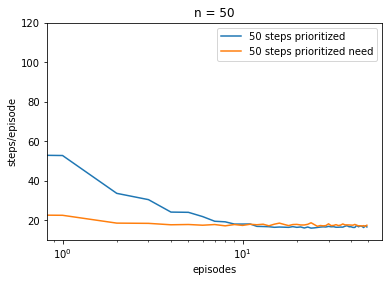

In [38]:
axes = plt.gca()
# axes.set_xlim([0, 20])
# axes.set_ylim([10, 120])
axes.set_xscale('log')
plt.xlabel("episodes")
plt.ylabel("steps/episode")
# plt.plot(dq_plan_0.steps_per_episode, label='0 steps')
# plt.plot(dq_plan_5.steps_per_episode, label='5 steps')
# plt.plot(dq_plan_50.steps_per_episode, label='50 steps')
plt.plot(np.mean(avg_steps_p_50, axis = 0), label='PS')
plt.plot(np.mean(avg_steps_p_need, axis = 0), label='PS-Need')
plt.legend()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


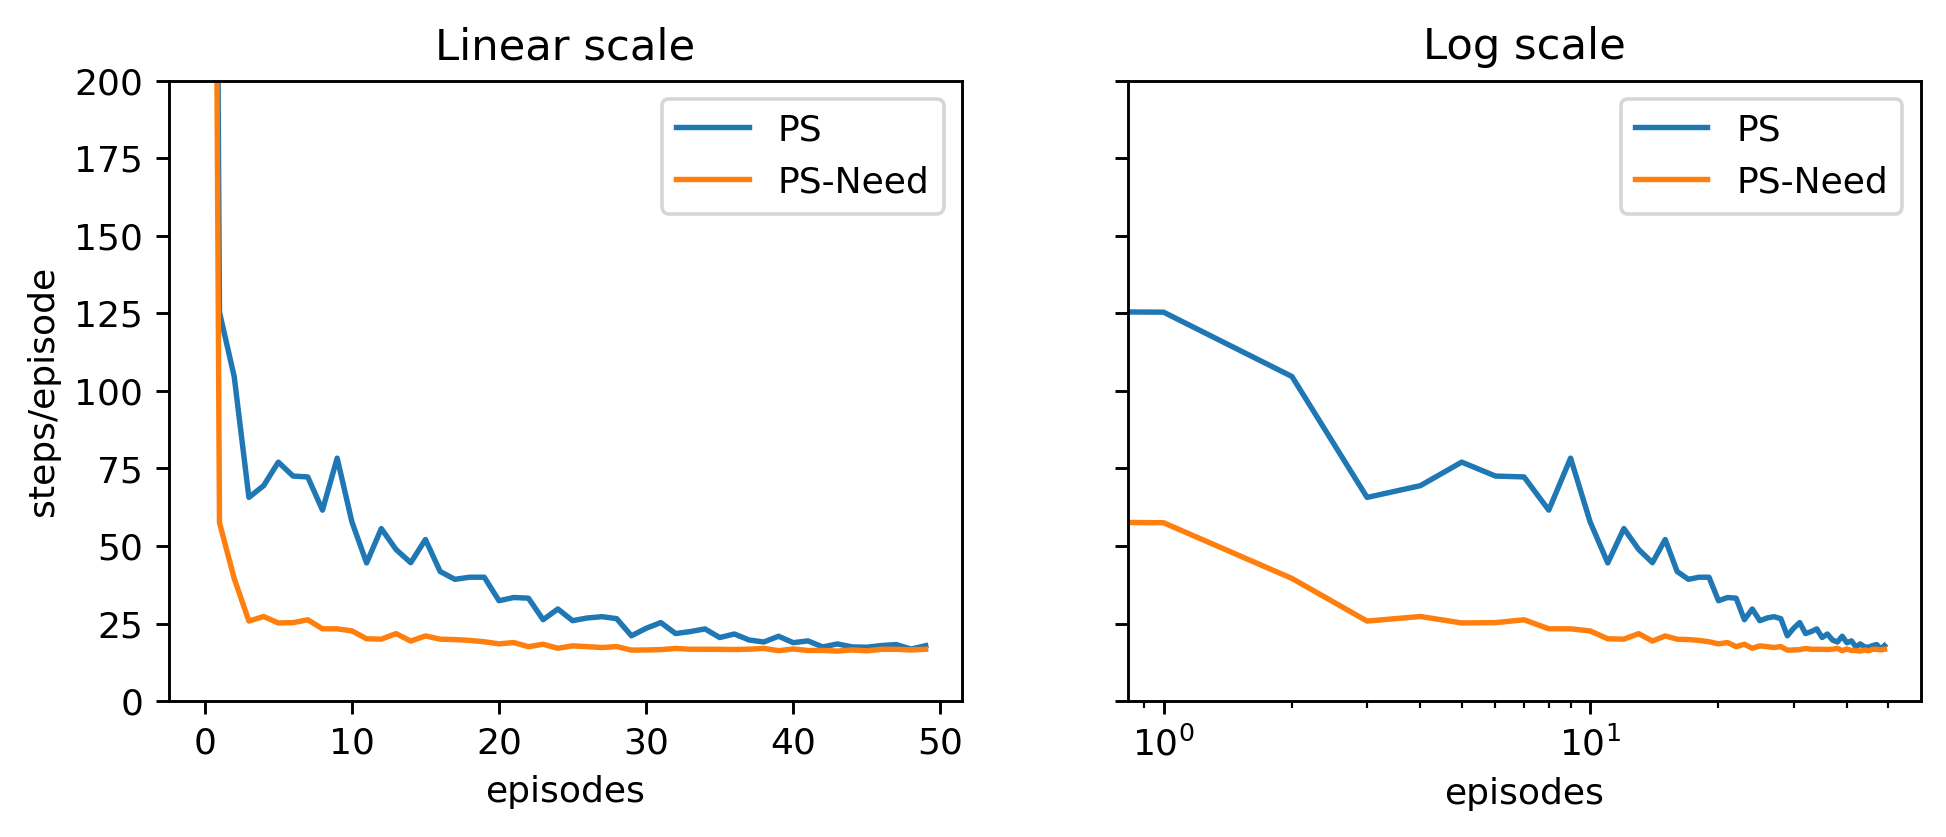

In [153]:
num_cols = 2
num_rows = 1
fig, axs = plt.subplots(num_rows, num_cols, figsize=(8, 3.5), sharey=True)
fig.tight_layout(pad=3.0)

# linear 
axs[0].set_xlabel("episodes")
axs[0].set_ylabel("steps/episode")
axs[0].plot(np.mean(avg_steps_p_50, axis = 0), label='PS')
axs[0].plot(np.mean(avg_steps_p_need, axis = 0), label='PS-Need')
axs[0].set_title('Linear scale')
axs[0].legend()

# log 
axs[1].set_xscale('log')
axs[1].set_xlabel("episodes")
axs[1].set_ylim([0, 200])
axs[1].plot(np.mean(avg_steps_p_50, axis = 0), label='PS')
axs[1].plot(np.mean(avg_steps_p_need, axis = 0), label='PS-Need')
axs[1].set_title('Log scale')
axs[1].legend()
plt.savefig('ps_need.eps', format='eps')

## TD Need term on different episodes

In [54]:
def data_lambda(lambda_M):
    times = 1
    custom_map = Maze.generate_custom_map([
        'FFFFFFFOG',
        'FFOFFFFOF',
        'SFOFFFFOF',
        'FFOFFFFFF',
        'FFFFFOFFF',
        'FFFFFFFFF'
    ], times)
    dq_need = Dyna_Q_Need(Maze(custom_map), need_mode='lambda')
    dq_need.lambda_M = lambda_M
    dq_need.alpha_M = 0.25
    dq_need.gamma_M = 0.9
    dq_need.stop_episodes = [i for i in range(101)]
    dq_need.run_prioritized(100, 20, "episode", gif_steps=-1, max_frames=600)
    return dq_need.need_matrix_episodes

In [55]:
def plot_episode(data, episode, ax):
    return sns.heatmap(data[episode].reshape((6, 9)), ax=ax, cmap="gray", cbar=False)

In [56]:
data_different_lambda = [data_lambda(x) for x in [0, 1.0]]

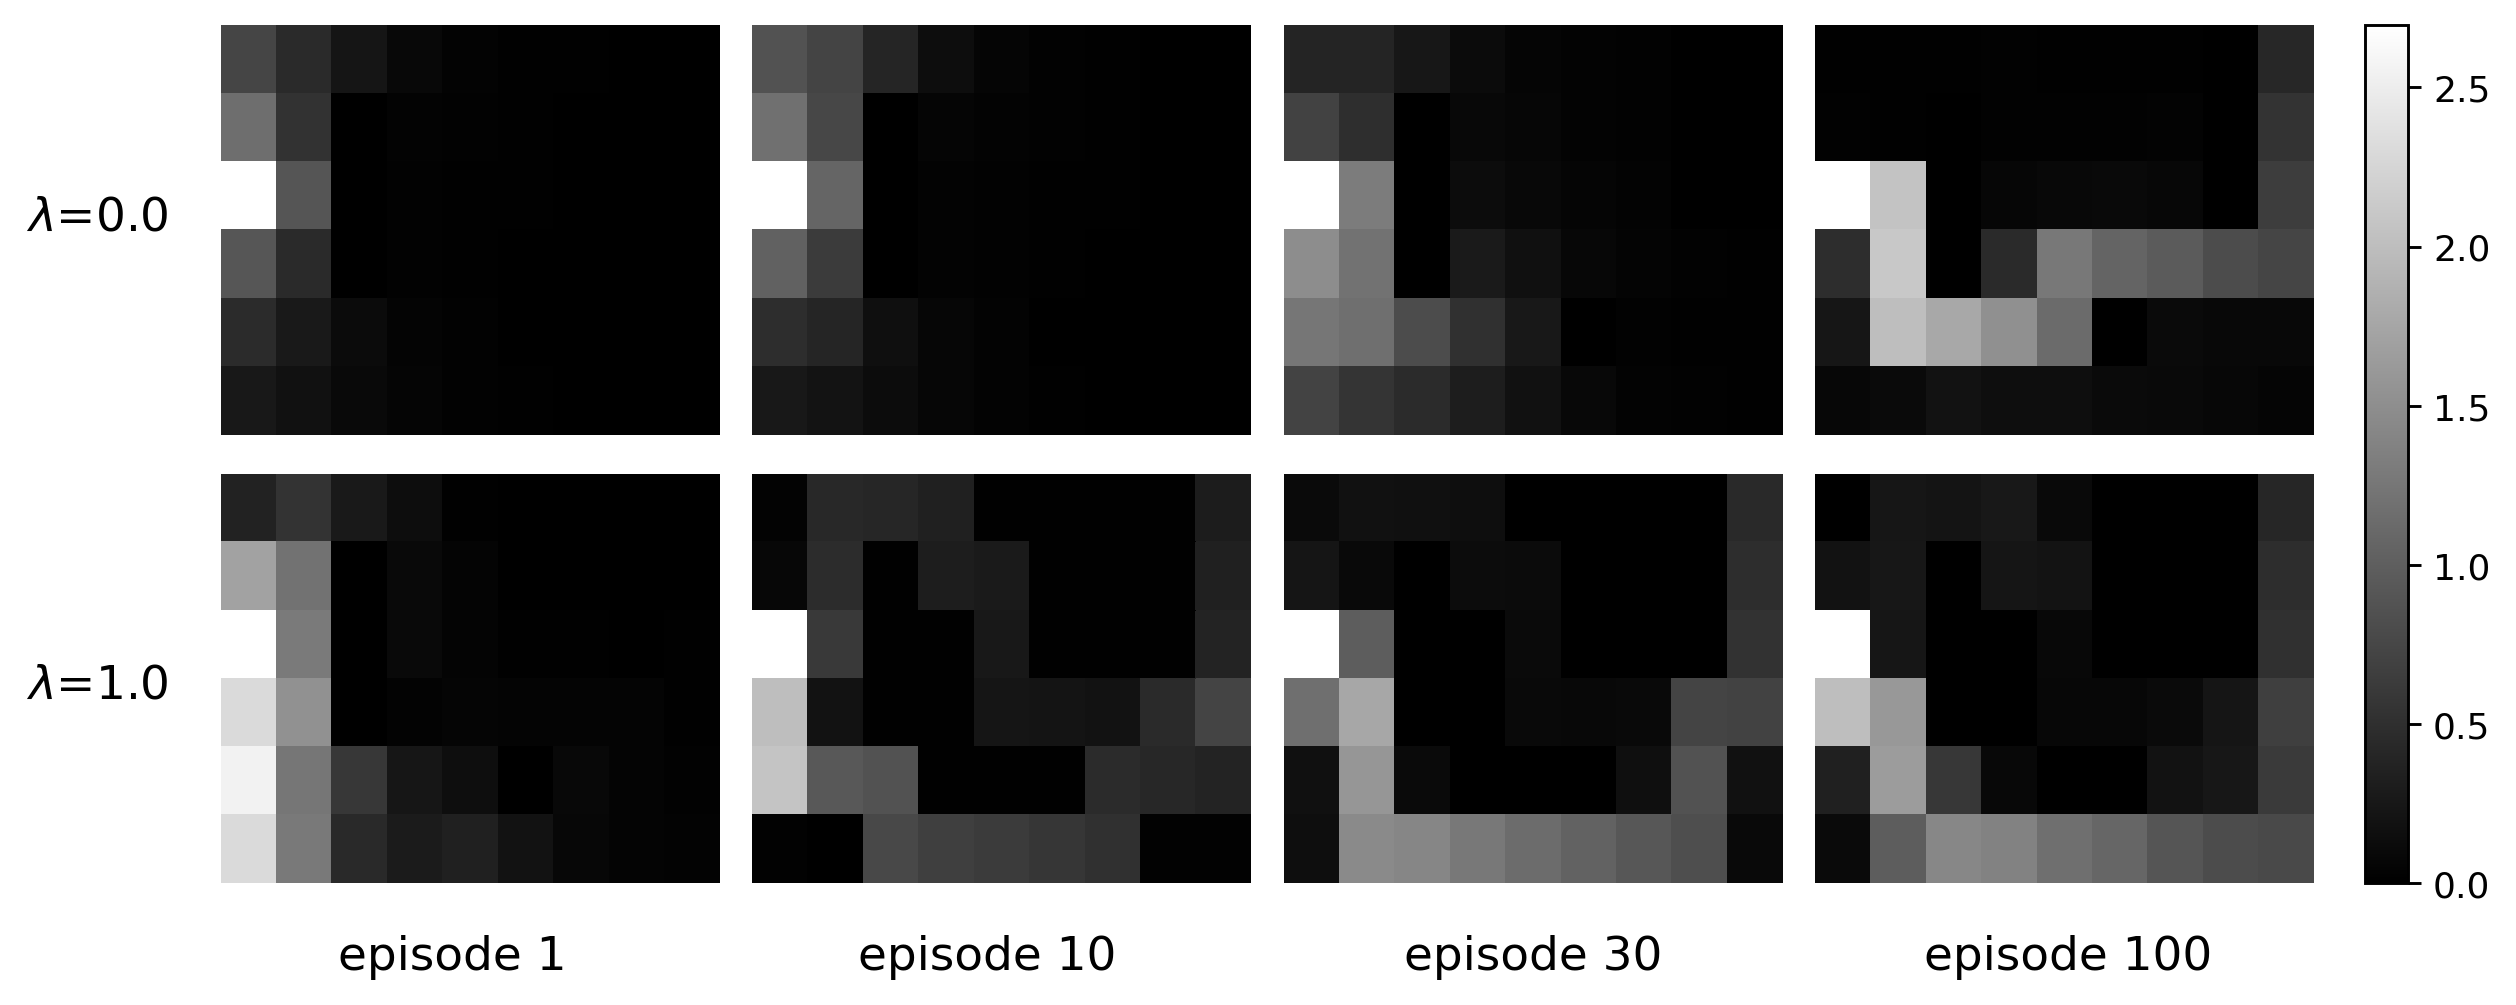

In [155]:
num_cols = 4
num_rows = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 3.6), sharey=True, sharex=True)
episodes = [1, 10, 30, 100]
ims = []
for i in range(num_cols * num_rows):
    curr_ax = axs[i // num_cols, i % num_cols]
    curr_lambda = i // num_cols
    im = plot_episode(data_different_lambda[curr_lambda], episodes[i % num_cols], curr_ax)
    ims.append(im)
    curr_ax.set(xlabel=None)
    curr_ax.set(ylabel=None)
    curr_ax.axes.get_xaxis().set_visible(False)
    curr_ax.axes.get_yaxis().set_visible(False)

# add margins
fig.tight_layout()

# lines = []
# labels = []

# for ax in fig.axes:
#     axLine, axLabel = ax.get_legend_handles_labels()
#     lines.extend(axLine)
#     labels.extend(axLabel)
# fig.legend(lines, labels, loc = 'lower center')

mappable = ims[0].get_children()[0]
plt.colorbar(mappable, ax = axs, orientation = 'vertical', pad=0.02)
fig.text(0.06, -0.05,'episode 1', fontsize=13)
fig.text(0.26, -0.05,'episode 10', fontsize=13)
fig.text(0.47, -0.05,'episode 30', fontsize=13)
fig.text(0.67, -0.05,'episode 100', fontsize=13)
fig.text(-0.06, 0.74, r'$\lambda$=0.0', fontsize=13)
fig.text(-0.06, 0.24, r'$\lambda$=1.0', fontsize=13)
plt.savefig("lambdas.eps", bbox_inches='tight')
plt.show()